# Reconocimiento de Objetos del Salón
## Álvaro Zarabanda - 20251595006

### Objetos a detectar
- 🧰 teclado  
- 🖱️ mouse  
- 💻 pantalla  
- 🖥️ cpu  
- 🪑 silla  
- 🧫 mesa
- ❌ nada (ruido)


In [4]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import math
from pathlib import Path
import warnings
import glob
warnings.filterwarnings('ignore')

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2DTranspose
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Configurar seeds para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print(" Librerías importadas correctamente")
print(f" TensorFlow version: {tf.__version__}")
print(f" Keras version: {keras.__version__}")

2025-10-22 23:23:07.784168: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-22 23:23:07.831060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 23:23:09.294316: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


 Librerías importadas correctamente
 TensorFlow version: 2.20.0
 Keras version: 3.11.3


## Constantes


In [5]:
# Configuración de rutas y parámetros
CODIGO = "20251595006"
PROCESSED_DIR = "../processed"
RAW_DIR = "../raw"
IMG_SIZE = (233, 233)
IMG_CHANNELS = 3
LATENT_DIM = 64  # Dimensión del espacio latente

# Mapeo de objetos
OBJETOS = ['cpu', 'mesa', 'mouse', 'pantalla', 'nada', 'silla', 'teclado']
NUM_CLASSES = len(OBJETOS)

print(f"Configuración:")
print(f"   - Código estudiante: {CODIGO}")
print(f"   - Dimensiones imagen: {IMG_SIZE} x {IMG_CHANNELS}")
print(f"   - Dimensión latente: {LATENT_DIM}")
print(f"   - Clases: {NUM_CLASSES} → {OBJETOS}")

Configuración:
   - Código estudiante: 20251595006
   - Dimensiones imagen: (233, 233) x 3
   - Dimensión latente: 64
   - Clases: 7 → ['cpu', 'mesa', 'mouse', 'pantalla', 'nada', 'silla', 'teclado']


## Extracción de frames

In [3]:
# DELETE FRAMES
# rm -f processed/cpu/20251595006_* processed/mesa/20251595006_* processed/mouse/20251595006_* processed/pantalla/20251595006_* processed/nada/20251595006_* processed/silla/20251595006_* processed/teclado/20251595006_*

def extract_frames_from_video(video_path, output_dir, codigo, objeto, target_size=(233, 233), max_frames=20):
    """
    Extrae frames de un video y los recorta al tamaño objetivo manteniendo la relación de aspecto
    
    Args:
        video_path: Ruta al archivo de video
        output_dir: Directorio donde guardar los frames
        codigo: Código del estudiante
        objeto: Tipo de objeto (cpu, mesa, mouse, etc.)
        target_size: Tamaño objetivo (ancho, alto)
        max_frames: Número fijo de frames a extraer por video
    """
    
    # Crear directorio si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Abrir el video
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {video_path}")
        return
    
    # Obtener información del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"Procesando {video_path}")
    print(f"  - FPS: {fps:.2f}")
    print(f"  - Total frames: {total_frames}")
    print(f"  - Duración: {duration:.2f} segundos")
    
    # Calcular intervalo para extraer exactamente max_frames frames
    if total_frames <= max_frames:
        frame_interval = 1  # Si hay pocos frames, tomar todos
        max_frames = total_frames
    else:
        frame_interval = total_frames // max_frames  # Distribuir uniformemente
    
    print(f"  - Extrayendo exactamente {max_frames} frames (intervalo: {frame_interval})")
    
    frame_count = 0
    extracted_count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret or extracted_count >= max_frames:
            break
            
        # Extraer solo cada frame_interval frames
        if frame_count % frame_interval == 0:
            # Obtener dimensiones originales
            h, w = frame.shape[:2]
            target_w, target_h = target_size
            
            # Calcular el factor de escala para mantener relación de aspecto
            # Escalar para que la dimensión menor coincida con el objetivo
            scale_w = target_w / w
            scale_h = target_h / h
            scale = max(scale_w, scale_h)  # Usar el mayor para que cubra completamente
            
            # Redimensionar manteniendo relación de aspecto
            new_w = int(w * scale)
            new_h = int(h * scale)
            resized_frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)
            
            # Calcular coordenadas para crop centrado
            start_x = (new_w - target_w) // 2
            start_y = (new_h - target_h) // 2
            end_x = start_x + target_w
            end_y = start_y + target_h
            
            # Asegurar que las coordenadas estén dentro de los límites
            start_x = max(0, start_x)
            start_y = max(0, start_y)
            end_x = min(new_w, end_x)
            end_y = min(new_h, end_y)
            
            # Recortar la imagen centrada
            cropped_frame = resized_frame[start_y:end_y, start_x:end_x]
            
            # Si el recorte no es exactamente del tamaño objetivo, redimensionar
            if cropped_frame.shape[:2] != (target_h, target_w):
                cropped_frame = cv2.resize(cropped_frame, target_size, interpolation=cv2.INTER_AREA)
            
            # Generar nombre del archivo
            frame_filename = f"{codigo}_{objeto}_{extracted_count+1:04d}.png"
            frame_path = os.path.join(output_dir, frame_filename)
            
            # Guardar frame
            cv2.imwrite(frame_path, cropped_frame, [cv2.IMWRITE_PNG_COMPRESSION, 6])
            
            extracted_count += 1
            print(f"  - Frame {extracted_count} extraído: {frame_filename}")
        
        frame_count += 1
    
    cap.release()
    print(f"  - Total frames extraídos: {extracted_count}\n")
    return extracted_count


In [ ]:
video_mapping = {
    "Cpu": "cpu",
    "Mesa": "mesa", 
    "Mouse": "mouse",
    "Pantalla": "pantalla",
    "Ruido": "nada",  
    "Silla": "silla",
    "Teclado": "teclado"
}

total_extracted = 0

print(f"Dimensiones objetivo: 233x233x3")
print(f"Método: Crop centrado (mantiene relación de aspecto)")
print(f"Directorio de videos: {RAW_DIR}")
print(f"Directorio de salida: {PROCESSED_DIR}")
print("=" * 60)

# Procesar cada video
for video_name, folder_name in video_mapping.items():
    video_file = f"{CODIGO}_{video_name}.mp4"
    video_path = os.path.join(RAW_DIR, video_file)
    output_dir = os.path.join(PROCESSED_DIR, folder_name)

    if os.path.exists(video_path):
        extracted = extract_frames_from_video(
            video_path, output_dir, CODIGO, folder_name, target_size=(233, 233)
        )
        total_extracted += extracted
    else:
        print(f"⚠️   Video no encontrado: {video_path}")

print("=" * 60)
print(f" PROCESO COMPLETADO")
print(f"Total de frames extraídos: {total_extracted}")
print(f"Videos procesados: {len(video_mapping)}")

# Verificar las carpetas de salida
print("\n RESUMEN POR CATEGORÍA:")
for folder_name in video_mapping.values():
    folder_path = os.path.join(PROCESSED_DIR, folder_name)
    if os.path.exists(folder_path):
        alvaro_files = [f for f in os.listdir(folder_path) if f.startswith(CODIGO)]
        print(f"  - {folder_name}: {len(alvaro_files)} frames")


Dimensiones objetivo: 233x233x3
Método: Crop centrado (mantiene relación de aspecto)
Directorio de videos: ../raw
Directorio de salida: ../processed
Procesando ../raw/20251595006_Cpu.mp4
  - FPS: 29.95
  - Total frames: 125
  - Duración: 4.17 segundos
  - Extrayendo exactamente 20 frames (intervalo: 6)
  - Frame 1 extraído: 20251595006_cpu_0001.png
  - Frame 2 extraído: 20251595006_cpu_0002.png
  - Frame 3 extraído: 20251595006_cpu_0003.png
  - Frame 4 extraído: 20251595006_cpu_0004.png
  - Frame 5 extraído: 20251595006_cpu_0005.png
  - Frame 6 extraído: 20251595006_cpu_0006.png
  - Frame 7 extraído: 20251595006_cpu_0007.png
  - Frame 8 extraído: 20251595006_cpu_0008.png
  - Frame 9 extraído: 20251595006_cpu_0009.png
  - Frame 10 extraído: 20251595006_cpu_0010.png
  - Frame 11 extraído: 20251595006_cpu_0011.png
  - Frame 12 extraído: 20251595006_cpu_0012.png
  - Frame 13 extraído: 20251595006_cpu_0013.png
  - Frame 14 extraído: 20251595006_cpu_0014.png
  - Frame 15 extraído: 2025159500

##  Carga y Exploración de Datos

In [6]:
def cargar_datos(processed_dir, objetos, img_size):
    """
    Carga TODAS las imágenes desde las carpetas processed (no solo de un estudiante específico)
    Redimensiona manteniendo relación de aspecto usando PADDING en blanco (sin recortar)
    Soporta formatos PNG y JPG
    """
    imagenes = []
    etiquetas = []
    rutas_archivos = []
    archivos_procesados = 0
    archivos_corregidos = 0
    
    def resize_con_padding(imagen, target_size):
        """
        Redimensiona manteniendo relación de aspecto y añade padding blanco
        NO recorta la imagen - conserva toda la información
        """
        h, w = imagen.shape[:2]
        target_w, target_h = target_size
        
        # Calcular factor de escala para que quepa completamente
        scale_w = target_w / w
        scale_h = target_h / h
        scale = min(scale_w, scale_h)  # Usar el MENOR para que quepa completamente
        
        # Redimensionar manteniendo relación de aspecto
        new_w = int(w * scale)
        new_h = int(h * scale)
        resized = cv2.resize(imagen, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Crear imagen con fondo blanco del tamaño objetivo
        resultado = np.ones((target_h, target_w, 3), dtype=imagen.dtype) * 255
        
        # Calcular posición para centrar la imagen redimensionada
        start_x = (target_w - new_w) // 2
        start_y = (target_h - new_h) // 2
        end_x = start_x + new_w
        end_y = start_y + new_h
        
        # Colocar la imagen redimensionada en el centro
        resultado[start_y:end_y, start_x:end_x] = resized
        
        return resultado
    
    print(" Cargando TODAS las imágenes de processed...")
    print(f" Dimensiones objetivo: {img_size[0]}x{img_size[1]}x3")
    print(f" Formatos soportados: PNG, JPG, JPEG")
    print(f" Método: PADDING con fondo blanco (SIN recorte)")
    print("=" * 60)
    
    for idx, objeto in enumerate(objetos):
        objeto_dir = os.path.join(processed_dir, objeto)
        if not os.path.exists(objeto_dir):
            print(f" Carpeta no encontrada: {objeto_dir}")
            continue
            
        # Buscar archivos de imagen en múltiples formatos
        archivos = [f for f in os.listdir(objeto_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f" {objeto}: {len(archivos)} imágenes encontradas")
        
        archivos_clase = 0
        corregidos_clase = 0
        formatos_encontrados = set()
        
        for archivo in archivos:
            ruta_completa = os.path.join(objeto_dir, archivo)
            
            # Registrar formato encontrado
            extension = archivo.lower().split('.')[-1]
            formatos_encontrados.add(extension.upper())
            
            # Cargar imagen
            img = cv2.imread(ruta_completa)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB
                original_shape = img.shape
                
                # Verificar si necesita corrección de dimensiones
                necesita_correccion = (img.shape[0] != img_size[1] or 
                                     img.shape[1] != img_size[0] or 
                                     img.shape[2] != 3)
                
                if necesita_correccion:
                    img = resize_con_padding(img, img_size)
                    corregidos_clase += 1
                    archivos_corregidos += 1
                    if corregidos_clase <= 3:  # Mostrar solo los primeros ejemplos
                        print(f"    {archivo}: {original_shape} → {img.shape} (con padding)")
                
                # Normalizar [0,1]
                img = img.astype(np.float32) / 255.0
                
                imagenes.append(img)
                etiquetas.append(idx)
                rutas_archivos.append(ruta_completa)
                archivos_clase += 1
                archivos_procesados += 1
            else:
                print(f"   Error cargando: {archivo}")
        
        if corregidos_clase > 3:
            print(f"    ... y {corregidos_clase - 3} imágenes más con padding")
        
        # Mostrar formatos encontrados en esta clase
        if formatos_encontrados:
            formatos_str = ", ".join(sorted(formatos_encontrados))
            print(f"    Formatos: {formatos_str}")
        
        print(f"    {archivos_clase} imágenes cargadas correctamente")
    
    print("=" * 60)
    print(f" RESUMEN FINAL:")
    print(f"   - Total imágenes procesadas: {archivos_procesados}")
    print(f"   - Imágenes con padding: {archivos_corregidos}")
    print(f"   - Imágenes sin modificar: {archivos_procesados - archivos_corregidos}")
    
    # Mostrar formatos globales encontrados
    all_extensions = set([os.path.splitext(r)[1].lower() for r in rutas_archivos])
    all_formats = [ext.replace('.', '').upper() for ext in all_extensions]
    print(f"   - Formatos procesados: {', '.join(sorted(all_formats))}")
    print(f"    NINGUNA imagen fue recortada - toda la información se conservó")
    
    return np.array(imagenes), np.array(etiquetas), rutas_archivos

# Cargar TODOS los datos de processed
print(" Iniciando carga completa del dataset...")
X, y, rutas = cargar_datos(PROCESSED_DIR, OBJETOS, IMG_SIZE)

print(f"\n DATASET FINAL:")
print(f"   - Forma de X: {X.shape}")
print(f"   - Forma de y: {y.shape}")
print(f"   - Rango de valores X: [{X.min():.3f}, {X.max():.3f}]")
print(f"   - Rango de valores Y: [{y.min()}, {y.max()}]")
print(f"   - Clases únicas: {np.unique(y)}")
print(f"   - Total estudiantes representados: {len(set([os.path.basename(r).split('_')[0] for r in rutas]))}")

# Verificar dimensiones finales
print(f"\n VERIFICACIÓN DE DIMENSIONES:")
shapes_unicas = set([img.shape for img in X])
print(f"   - Formas únicas en el dataset: {shapes_unicas}")
if len(shapes_unicas) == 1:
    print("    Todas las imágenes tienen dimensiones consistentes")
else:
    print("    Hay inconsistencias en las dimensiones")

# Verificar que el fondo es blanco en las imágenes con padding
print(f"\n VERIFICACIÓN DE PADDING:")
sample_img = X[0]
corners = [
    sample_img[0, 0],      # esquina superior izquierda
    sample_img[0, -1],     # esquina superior derecha  
    sample_img[-1, 0],     # esquina inferior izquierda
    sample_img[-1, -1]     # esquina inferior derecha
]
corner_values = [np.mean(corner) for corner in corners]
print(f"   - Valores promedio en esquinas: {corner_values}")
if all(val > 0.9 for val in corner_values):
    print("    Las esquinas son blancas (padding aplicado correctamente)")
else:
    print("   ℹ Las esquinas no son completamente blancas (imagen ocupa todo el espacio)")

 Iniciando carga completa del dataset...
 Cargando TODAS las imágenes de processed...
 Dimensiones objetivo: 233x233x3
 Formatos soportados: PNG, JPG, JPEG
 Método: PADDING con fondo blanco (SIN recorte)
 cpu: 199 imágenes encontradas
    20251695004_cpu_0007.png: (850, 478, 3) → (233, 233, 3) (con padding)
    20242595003_cpu_0008.png: (1280, 720, 3) → (233, 233, 3) (con padding)
    20251695007_CPU_022.png: (480, 848, 3) → (233, 233, 3) (con padding)
    ... y 176 imágenes más con padding
    Formatos: JPG, PNG
    199 imágenes cargadas correctamente
 mesa: 233 imágenes encontradas
    20242595003_mesa_0008.png: (1280, 720, 3) → (233, 233, 3) (con padding)
    20241695014_mesa_0002.png: (480, 848, 3) → (233, 233, 3) (con padding)
    20242595003_mesa_0042.png: (1280, 720, 3) → (233, 233, 3) (con padding)
    ... y 210 imágenes más con padding
    Formatos: JPG, PNG
    233 imágenes cargadas correctamente
 mouse: 218 imágenes encontradas
    20251695007_mouse_017.png: (848, 480, 3) → 

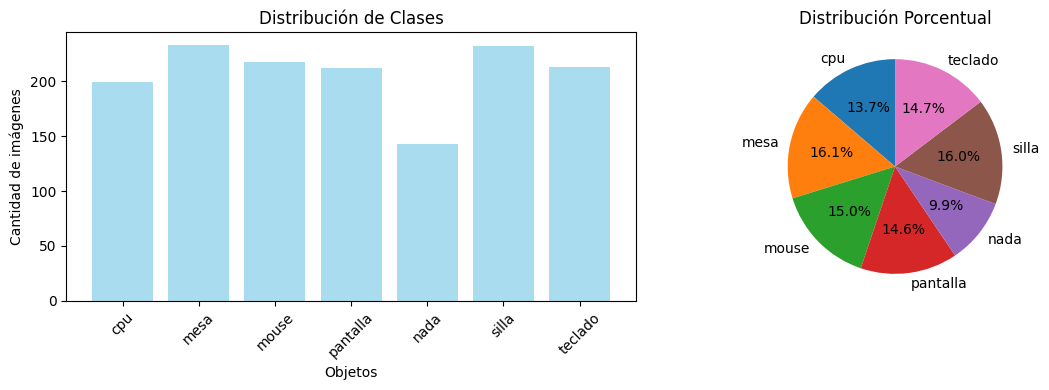

Estadísticas por clase:
          cpu: 199 imágenes ( 13.7%)
         mesa: 233 imágenes ( 16.1%)
        mouse: 218 imágenes ( 15.0%)
     pantalla: 212 imágenes ( 14.6%)
         nada: 143 imágenes (  9.9%)
        silla: 232 imágenes ( 16.0%)
      teclado: 213 imágenes ( 14.7%)


In [7]:
# Visualizar distribución de clases
plt.figure(figsize=(12, 4))

# Subplot 1: Conteo por clase
plt.subplot(1, 2, 1)
class_counts = np.bincount(y)
plt.bar(OBJETOS, class_counts, color='skyblue', alpha=0.7)
plt.title('Distribución de Clases')
plt.xlabel('Objetos')
plt.ylabel('Cantidad de imágenes')
plt.xticks(rotation=45)

# Subplot 2: Porcentajes
plt.subplot(1, 2, 2)
percentages = class_counts / len(y) * 100
plt.pie(percentages, labels=OBJETOS, autopct='%1.1f%%', startangle=90)
plt.title('Distribución Porcentual')

plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas
print("Estadísticas por clase:")
for i, objeto in enumerate(OBJETOS):
    count = class_counts[i]
    pct = percentages[i]
    print(f"   {objeto:>10}: {count:>2} imágenes ({pct:>5.1f}%)")

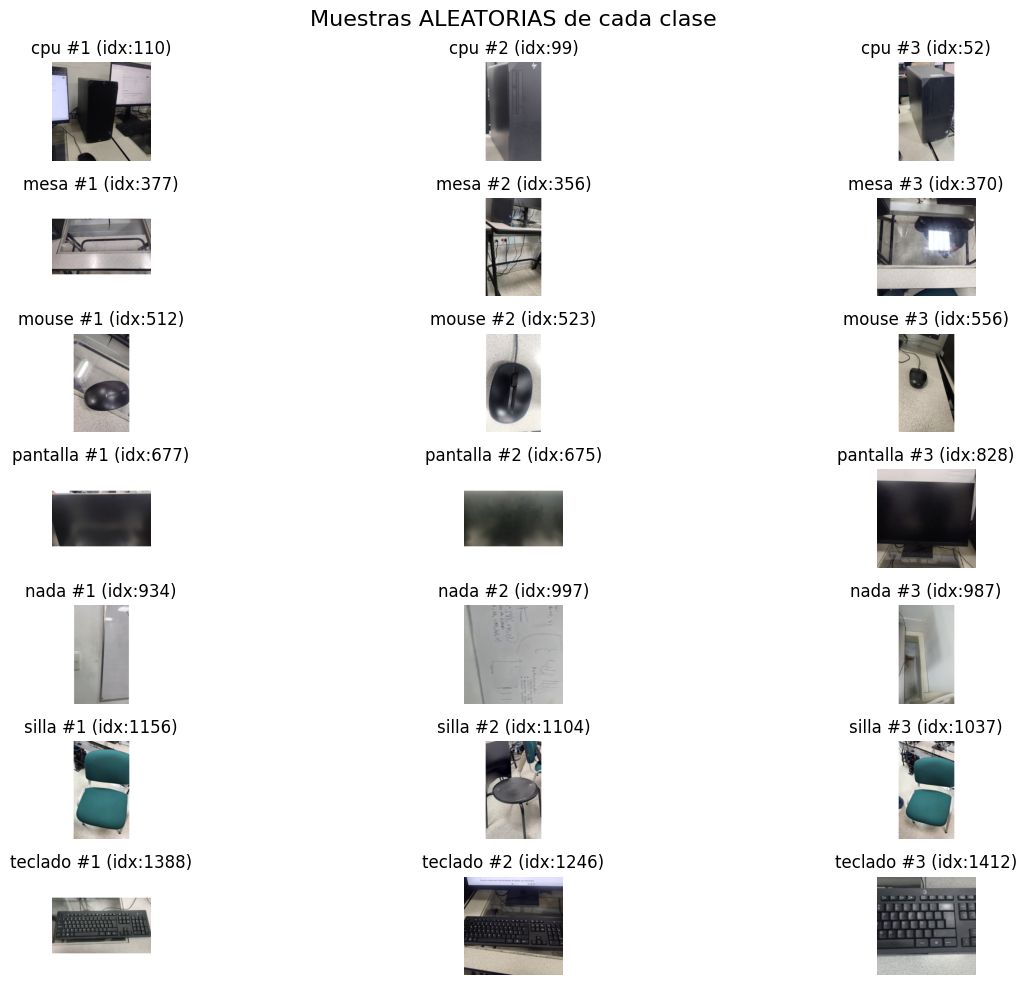

In [8]:
# Visualizar muestras aleatorias de cada clase
plt.figure(figsize=(15, 10))

# Configurar seed para reproducibilidad (opcional)
np.random.seed(None)  # Cambia a un número fijo si quieres resultados reproducibles

for i, objeto in enumerate(OBJETOS):
    # Encontrar imágenes de esta clase
    indices_clase = np.where(y == i)[0]
    
    if len(indices_clase) > 0:
        # Seleccionar hasta 3 ejemplos ALEATORIOS por clase
        num_ejemplos = min(3, len(indices_clase))
        indices_aleatorios = np.random.choice(indices_clase, size=num_ejemplos, replace=False)
        
        for j in range(num_ejemplos):
            plt.subplot(len(OBJETOS), 3, i * 3 + j + 1)
            
            idx = indices_aleatorios[j]
            img = X[idx]
            
            plt.imshow(img)
            plt.title(f'{objeto} #{j+1} (idx:{idx})')
            plt.axis('off')
    else:
        # Si no hay imágenes de esta clase
        plt.subplot(len(OBJETOS), 3, i * 3 + 1)
        plt.text(0.5, 0.5, f'No hay\nimágenes de\n{objeto}', 
                ha='center', va='center', fontsize=12)
        plt.axis('off')

plt.suptitle('Muestras ALEATORIAS de cada clase', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

##  Construcción del Autoencoder

In [9]:
class Autoencoder(keras.Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        
        # Build the encoder
        self.encoder = keras.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=shape),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu', name='latent_space')
        ], name='encoder')
        
        # Calcular las dimensiones después de las capas convolucionales
        # Para 233x233 con padding='same': 233 -> 117 -> 59 (con MaxPooling2D)
        import math
        conv_output_h = math.ceil(math.ceil(shape[0] / 2) / 2)  # 233 -> 117 -> 59
        conv_output_w = math.ceil(math.ceil(shape[1] / 2) / 2)  # 233 -> 117 -> 59
        conv_output_channels = 64
        
        # Build the decoder - usando layers más sofisticadas para reconstrucción exacta
        self.decoder = keras.Sequential([
            layers.Dense(conv_output_h * conv_output_w * conv_output_channels, activation='relu'),
            layers.Reshape((conv_output_h, conv_output_w, conv_output_channels)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(shape[2], (3, 3), activation='sigmoid', padding='same'),
            # Capa de ajuste final para obtener exactamente las dimensiones originales
            layers.Lambda(lambda x: tf.image.resize(x, [shape[0], shape[1]], method='bilinear'))
        ], name='decoder')

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Método para extraer solo las features del encoder"""
        return self.encoder(x)

# Crear autoencoder usando tu clase personalizada
input_shape = (IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS)
autoencoder = Autoencoder(LATENT_DIM, input_shape)

# Compilar autoencoder
autoencoder.compile(
    optimizer='adam',
    loss='mse',  # Mean Squared Error para reconstrucción
    metrics=['mae']  # Mean Absolute Error
)

print("Autoencoder personalizado creado")
print(f"Configuración:")
print(f"   - Forma de entrada: {input_shape}")
print(f"   - Dimensión latente: {LATENT_DIM}")
print(f"   - Parámetros totales: {tf.math.reduce_prod(input_shape).numpy()} -> {LATENT_DIM}")

# Construir el modelo pasando datos de ejemplo
sample_data = tf.random.normal((1,) + input_shape)
_ = autoencoder(sample_data)

print(f"   - Encoder: {autoencoder.encoder.count_params()} parámetros")
print(f"   - Decoder: {autoencoder.decoder.count_params()} parámetros")

2025-10-22 23:23:45.449112: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Autoencoder personalizado creado
Configuración:
   - Forma de entrada: (233, 233, 3)
   - Dimensión latente: 64
   - Parámetros totales: 162867 -> 64
   - Encoder: 14277632 parámetros
   - Decoder: 14537219 parámetros


In [10]:
# Mostrar arquitectura del autoencoder
print("Arquitectura del Encoder:")
autoencoder.encoder.summary()

print("\nArquitectura del Decoder:")
autoencoder.decoder.summary()

print("\nAutoencoder completo:")
print(f"Input shape: {input_shape}")
print(f"Latent dimension: {LATENT_DIM}")
print(f"Output shape: {input_shape}")
print(f"Compression ratio: {tf.math.reduce_prod(input_shape).numpy() / LATENT_DIM:.1f}x")

Arquitectura del Encoder:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 233, 233, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 117, 117, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 222784)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 64)             │    14,258,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,277,632 (54.46 MB)

 Trainable params: 14,277,632 (54.46 MB)

 Non-trainable params: 0 (0.00 B)


Arquitectura del Decoder:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (1, 222784)            │    14,480,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (1, 59, 59, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (1, 59, 59, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (1, 118, 118, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (1, 118, 118, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (1, 236, 236, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (1, 236, 236, 3)       │           867 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (1, 233, 233, 3)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,537,219 (55.46 MB)

 Trainable params: 14,537,219 (55.46 MB)

 Non-trainable params: 0 (0.00 B)


Autoencoder completo:
Input shape: (233, 233, 3)
Latent dimension: 64
Output shape: (233, 233, 3)
Compression ratio: 2544.8x


##  Entrenamiento del Autoencoder

In [11]:
# El autoencoder aprende a reconstruir TODAS las imágenes (sin usar etiquetas)

# Se hace una division de datos balanceada por clase
X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" División de datos para autoencoder:")
print(f"   - Entrenamiento: {X_train_ae.shape[0]} imágenes")
print(f"   - Prueba: {X_test_ae.shape[0]} imágenes")

# Verificar distribución balanceada
print(f"\nDistribución por clase en entrenamiento:")
train_counts = np.bincount(y_train_ae)
for i, objeto in enumerate(OBJETOS):
    print(f"   {objeto:>10}: {train_counts[i]} imágenes ({train_counts[i]/len(y_train_ae)*100:.1f}%)")

print(f"\nDistribución por clase en prueba:")
test_counts = np.bincount(y_test_ae)
for i, objeto in enumerate(OBJETOS):
    print(f"   {objeto:>10}: {test_counts[i]} imágenes ({test_counts[i]/len(y_test_ae)*100:.1f}%)")

# Verificar si el modelo autoencoder ya existe
autoencoder_weights_path = "../models/20251595006_autoencoder.weights.h5"

if os.path.exists(autoencoder_weights_path):
    print(f" Cargando autoencoder pre-entrenado desde: {autoencoder_weights_path}")
    autoencoder.load_weights(autoencoder_weights_path)
    print(" Autoencoder cargado exitosamente!")
    
    # Evaluar el modelo cargado
    test_loss, test_mae = autoencoder.evaluate(X_test_ae, X_test_ae, verbose=0)
    print(f" Rendimiento del autoencoder cargado:")
    print(f"   - MSE Loss: {test_loss:.4f}")
    print(f"   - MAE: {test_mae:.4f}")
    
    # Crear un historial dummy para compatibilidad con el resto del código
    history_ae = type('History', (), {
        'history': {
            'loss': [test_loss],
            'val_loss': [test_loss], 
            'mae': [test_mae],
            'val_mae': [test_mae]
        }
    })()
    
else:
    print(f" No se encontró modelo pre-entrenado en: {autoencoder_weights_path}")
    print(" Entrenando autoencoder desde cero...")
    
    # Callbacks para entrenamiento
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7
        )
    ]

    # Entrenar autoencoder
    print("\n Iniciando entrenamiento del autoencoder...")
    history_ae = autoencoder.fit(
        X_train_ae, X_train_ae,  # Input = Output (reconstrucción)
        validation_data=(X_test_ae, X_test_ae),
        epochs=20,
        batch_size=100,  
        callbacks=callbacks,
        verbose=1
    )

    print(" Autoencoder entrenado!")
    
    # Guardar el modelo recién entrenado
    os.makedirs("../models", exist_ok=True)
    autoencoder.save_weights(autoencoder_weights_path)
    print(f" Autoencoder guardado en: {autoencoder_weights_path}")

 División de datos para autoencoder:
   - Entrenamiento: 1160 imágenes
   - Prueba: 290 imágenes

Distribución por clase en entrenamiento:
          cpu: 159 imágenes (13.7%)
         mesa: 186 imágenes (16.0%)
        mouse: 175 imágenes (15.1%)
     pantalla: 170 imágenes (14.7%)
         nada: 114 imágenes (9.8%)
        silla: 186 imágenes (16.0%)
      teclado: 170 imágenes (14.7%)

Distribución por clase en prueba:
          cpu: 40 imágenes (13.8%)
         mesa: 47 imágenes (16.2%)
        mouse: 43 imágenes (14.8%)
     pantalla: 42 imágenes (14.5%)
         nada: 29 imágenes (10.0%)
        silla: 46 imágenes (15.9%)
      teclado: 43 imágenes (14.8%)
 Cargando autoencoder pre-entrenado desde: ../models/20251595006_autoencoder.weights.h5
 Autoencoder cargado exitosamente!


2025-10-22 23:23:52.183544: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 188925720 exceeds 10% of free system memory.
2025-10-22 23:23:52.420301: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 188925720 exceeds 10% of free system memory.
2025-10-22 23:23:53.037276: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 222367744 exceeds 10% of free system memory.
2025-10-22 23:23:53.212994: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 228130816 exceeds 10% of free system memory.
2025-10-22 23:23:53.286954: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 222367744 exceeds 10% of free system memory.


 Rendimiento del autoencoder cargado:
   - MSE Loss: 0.0129
   - MAE: 0.0671


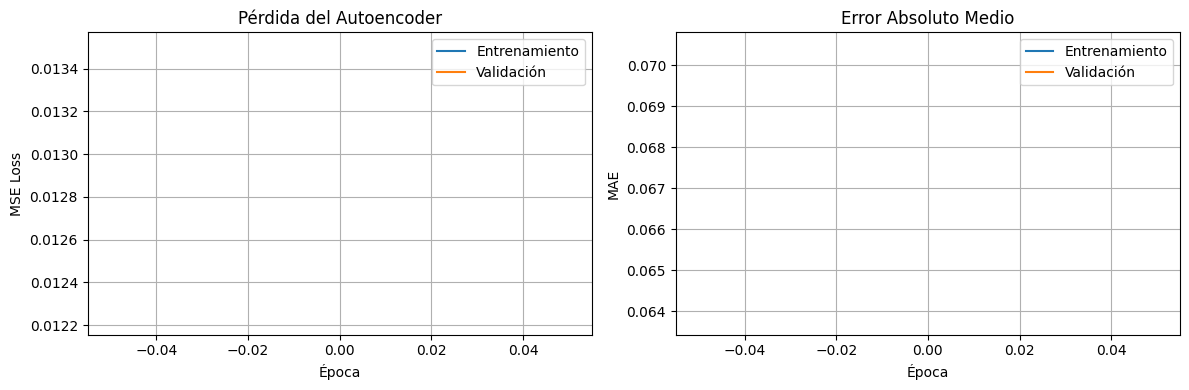

 Rendimiento del autoencoder en test:
   - MSE Loss: 0.0129
   - MAE: 0.0671


In [12]:
# Visualizar progreso del entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_ae.history['loss'], label='Entrenamiento')
plt.plot(history_ae.history['val_loss'], label='Validación')
plt.title('Pérdida del Autoencoder')
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_ae.history['mae'], label='Entrenamiento')
plt.plot(history_ae.history['val_mae'], label='Validación')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar autoencoder
test_loss, test_mae = autoencoder.evaluate(X_test_ae, X_test_ae, verbose=0)
print(f" Rendimiento del autoencoder en test:")
print(f"   - MSE Loss: {test_loss:.4f}")
print(f"   - MAE: {test_mae:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


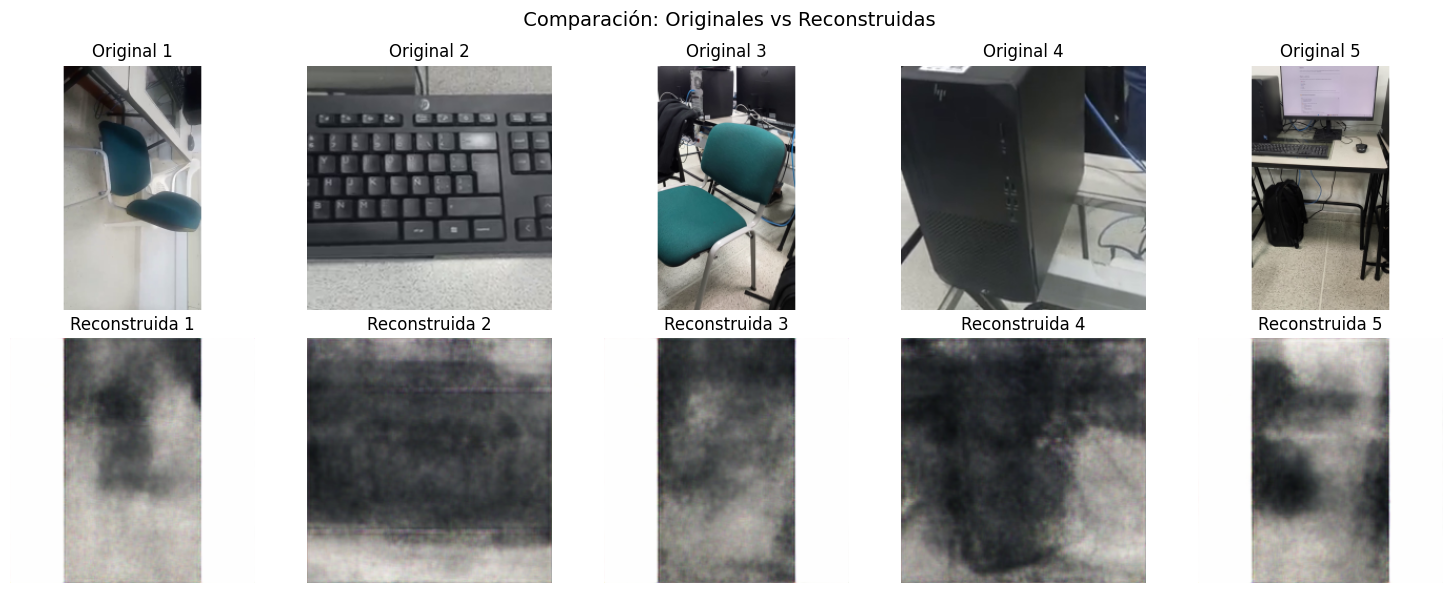

In [13]:
# Visualizar reconstrucciones del autoencoder
n_examples = 5
test_indices = np.random.choice(len(X_test_ae), n_examples, replace=False)

# Generar reconstrucciones
reconstructed = autoencoder.predict(X_test_ae[test_indices])

plt.figure(figsize=(15, 6))
for i in range(n_examples):
    # Imagen original
    plt.subplot(2, n_examples, i + 1)
    plt.imshow(X_test_ae[test_indices[i]])
    plt.title(f'Original {i+1}')
    plt.axis('off')
    
    # Imagen reconstruida
    plt.subplot(2, n_examples, i + 1 + n_examples)
    plt.imshow(reconstructed[i])
    plt.title(f'Reconstruida {i+1}')
    plt.axis('off')

plt.suptitle(' Comparación: Originales vs Reconstruidas', fontsize=14)
plt.tight_layout()
plt.show()

##  Construcción del Clasificador
### Usando features del Encoder

In [14]:
# Extraer features usando el método encode del autoencoder
print(" Extrayendo features con el encoder...")
X_features = autoencoder.encode(X).numpy()  # Usar el método encode

print(f" Features extraídas:")
print(f"   - Forma original X: {X.shape}")
print(f"   - Forma features: {X_features.shape}")
print(f"   - Reducción dimensional: {X.shape[1]*X.shape[2]*X.shape[3]} -> {X_features.shape[1]}")
print(f"   - Factor de compresión: {(X.shape[1]*X.shape[2]*X.shape[3]) / X_features.shape[1]:.1f}x")

# Preparar datos para clasificación
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

# Convertir etiquetas a categóricas (hace one-hot encoding)
y_train_cat = keras.utils.to_categorical(y_train_clf, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test_clf, NUM_CLASSES)

print(f"\n División de datos para clasificador:")
print(f"   - Entrenamiento: {X_train_clf.shape[0]} muestras")
print(f"   - Prueba: {X_test_clf.shape[0]} muestras")
print(f"   - Forma de features: {X_train_clf.shape[1:]}")
print(f"   - Clases: {NUM_CLASSES}")

 Extrayendo features con el encoder...
 Features extraídas:
   - Forma original X: (1450, 233, 233, 3)
   - Forma features: (1450, 64)
   - Reducción dimensional: 162867 -> 64
   - Factor de compresión: 2544.8x

 División de datos para clasificador:
   - Entrenamiento: 1160 muestras
   - Prueba: 290 muestras
   - Forma de features: (64,)
   - Clases: 7


In [15]:
def crear_clasificador(input_dim, num_classes):
    """
    Clasificador que toma features del encoder y predice clase
    """
    inputs = keras.Input(shape=(input_dim,), name='classifier_input')
    
    # Red neuronal para clasificación
    x = layers.Dense(256, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Capa de salida con softmax para clasificación multiclase
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    classifier = keras.Model(inputs, outputs, name='classifier')
    return classifier

# Crear y compilar clasificador
classifier = crear_clasificador(LATENT_DIM, NUM_CLASSES)

classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" Clasificador creado")
print(" Arquitectura del clasificador:")
classifier.summary()

 Clasificador creado
 Arquitectura del clasificador:


Model: "classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ classifier_input (InputLayer)   │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,247 (227.53 KB)

 Trainable params: 58,247 (227.53 KB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento del Clasificador

In [16]:
# Verificar si el modelo clasificador ya existe
classifier_path = "../models/20251595006_classifier.h5"

if os.path.exists(classifier_path):
    print(f" Cargando clasificador pre-entrenado desde: {classifier_path}")
    classifier = keras.models.load_model(classifier_path)
    print(" Clasificador cargado exitosamente!")
    
    # Evaluar el modelo cargado
    test_loss_clf, test_acc_clf = classifier.evaluate(X_test_clf, y_test_cat, verbose=0)
    print(f" Rendimiento del clasificador cargado:")
    print(f"   - Accuracy: {test_acc_clf:.4f} ({test_acc_clf*100:.2f}%)")
    print(f"   - Loss: {test_loss_clf:.4f}")
    
    # Crear un historial dummy para compatibilidad con el resto del código
    history_clf = type('History', (), {
        'history': {
            'accuracy': [test_acc_clf],
            'val_accuracy': [test_acc_clf],
            'loss': [test_loss_clf],
            'val_loss': [test_loss_clf]
        }
    })()
    
else:
    print(f" No se encontró modelo pre-entrenado en: {classifier_path}")
    print(" Entrenando clasificador desde cero...")
    
    # Callbacks para clasificador
    callbacks_clf = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            mode='max'
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=8,
            min_lr=1e-7
        )
    ]

    # Entrenar clasificador
    print("\n Iniciando entrenamiento del clasificador...")
    history_clf = classifier.fit(
        X_train_clf, y_train_cat,
        validation_data=(X_test_clf, y_test_cat),
        epochs=100,
        batch_size=8,
        callbacks=callbacks_clf,
        verbose=1
    )

    print(" Clasificador entrenado!")
    
    # Guardar el modelo recién entrenado
    os.makedirs("../models", exist_ok=True)
    classifier.save(classifier_path)
    print(f" Clasificador guardado en: {classifier_path}")

 No se encontró modelo pre-entrenado en: ../models/20251595006_classifier.h5
 Entrenando clasificador desde cero...

 Iniciando entrenamiento del clasificador...
Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2440 - loss: 3.5983 - val_accuracy: 0.5241 - val_loss: 1.5625 - learning_rate: 0.0010
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3543 - loss: 1.8989 - val_accuracy: 0.6138 - val_loss: 1.3910 - learning_rate: 0.0010
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4466 - loss: 1.5537 - val_accuracy: 0.7000 - val_loss: 1.1760 - learning_rate: 0.0010
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5336 - loss: 1.3391 - val_accuracy: 0.7586 - val_loss: 0.9557 - learning_rate: 0.0010
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5879 - loss: 1.1681 - val_accuracy: 0.7690 - val_loss: 0.8156 - learning_rate: 0.0010
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6198 -

 Clasificador entrenado!
 Clasificador guardado en: ../models/20251595006_classifier.h5


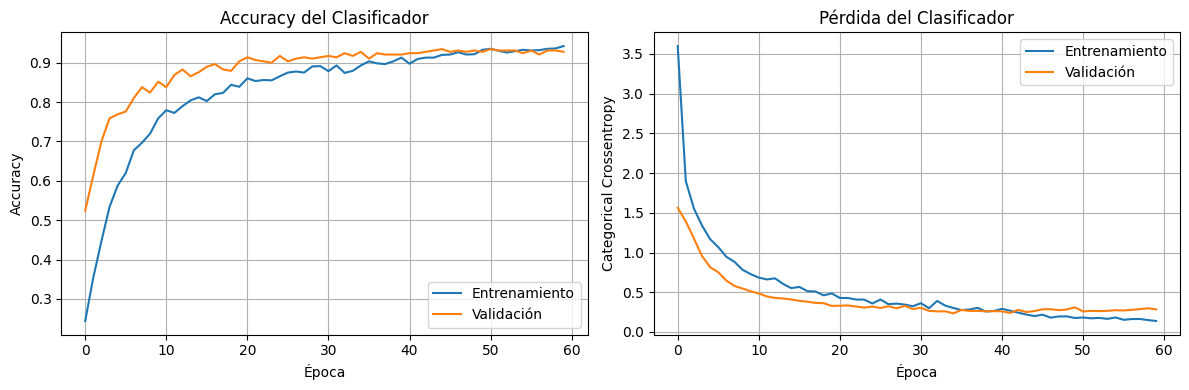

 Rendimiento del clasificador en test:
   - Accuracy: 0.9345 (93.45%)
   - Loss: 0.2635


In [17]:
# Visualizar progreso del entrenamiento del clasificador
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_clf.history['accuracy'], label='Entrenamiento')
plt.plot(history_clf.history['val_accuracy'], label='Validación')
plt.title('Accuracy del Clasificador')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_clf.history['loss'], label='Entrenamiento')
plt.plot(history_clf.history['val_loss'], label='Validación')
plt.title('Pérdida del Clasificador')
plt.xlabel('Época')
plt.ylabel('Categorical Crossentropy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluar clasificador
test_loss_clf, test_acc_clf = classifier.evaluate(X_test_clf, y_test_cat, verbose=0)
print(f" Rendimiento del clasificador en test:")
print(f"   - Accuracy: {test_acc_clf:.4f} ({test_acc_clf*100:.2f}%)")
print(f"   - Loss: {test_loss_clf:.4f}")

## Evaluación y Análisis de Resultados

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


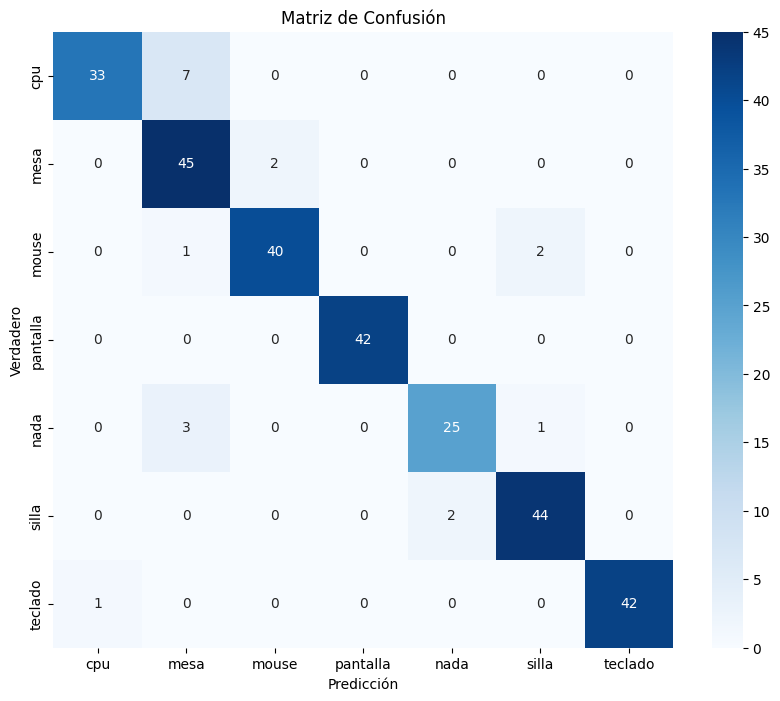

 Reporte de clasificación:
              precision    recall  f1-score   support

         cpu       0.97      0.82      0.89        40
        mesa       0.80      0.96      0.87        47
       mouse       0.95      0.93      0.94        43
    pantalla       1.00      1.00      1.00        42
        nada       0.93      0.86      0.89        29
       silla       0.94      0.96      0.95        46
     teclado       1.00      0.98      0.99        43

    accuracy                           0.93       290
   macro avg       0.94      0.93      0.93       290
weighted avg       0.94      0.93      0.93       290


 Accuracy por clase:
          cpu: 0.825 (82.5%)
         mesa: 0.957 (95.7%)
        mouse: 0.930 (93.0%)
     pantalla: 1.000 (100.0%)
         nada: 0.862 (86.2%)
        silla: 0.957 (95.7%)
      teclado: 0.977 (97.7%)


In [18]:
# Hacer predicciones
y_pred_proba = classifier.predict(X_test_clf)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=OBJETOS, yticklabels=OBJETOS)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Reporte de clasificación
print(" Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=OBJETOS))

# Accuracy por clase
print("\n Accuracy por clase:")
for i, objeto in enumerate(OBJETOS):
    mask = y_true == i
    if np.sum(mask) > 0:
        acc_clase = np.mean(y_pred[mask] == y_true[mask])
        print(f"   {objeto:>10}: {acc_clase:.3f} ({acc_clase*100:.1f}%)")

Seleccionando muestras aleatorias por clase:
          cpu: muestra #117 seleccionada
         mesa: muestra #222 seleccionada
        mouse: muestra #64 seleccionada
     pantalla: muestra #4 seleccionada
         nada: muestra #130 seleccionada
        silla: muestra #273 seleccionada
      teclado: muestra #51 seleccionada
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Mostrando predicciones para 7 muestras aleatorias:


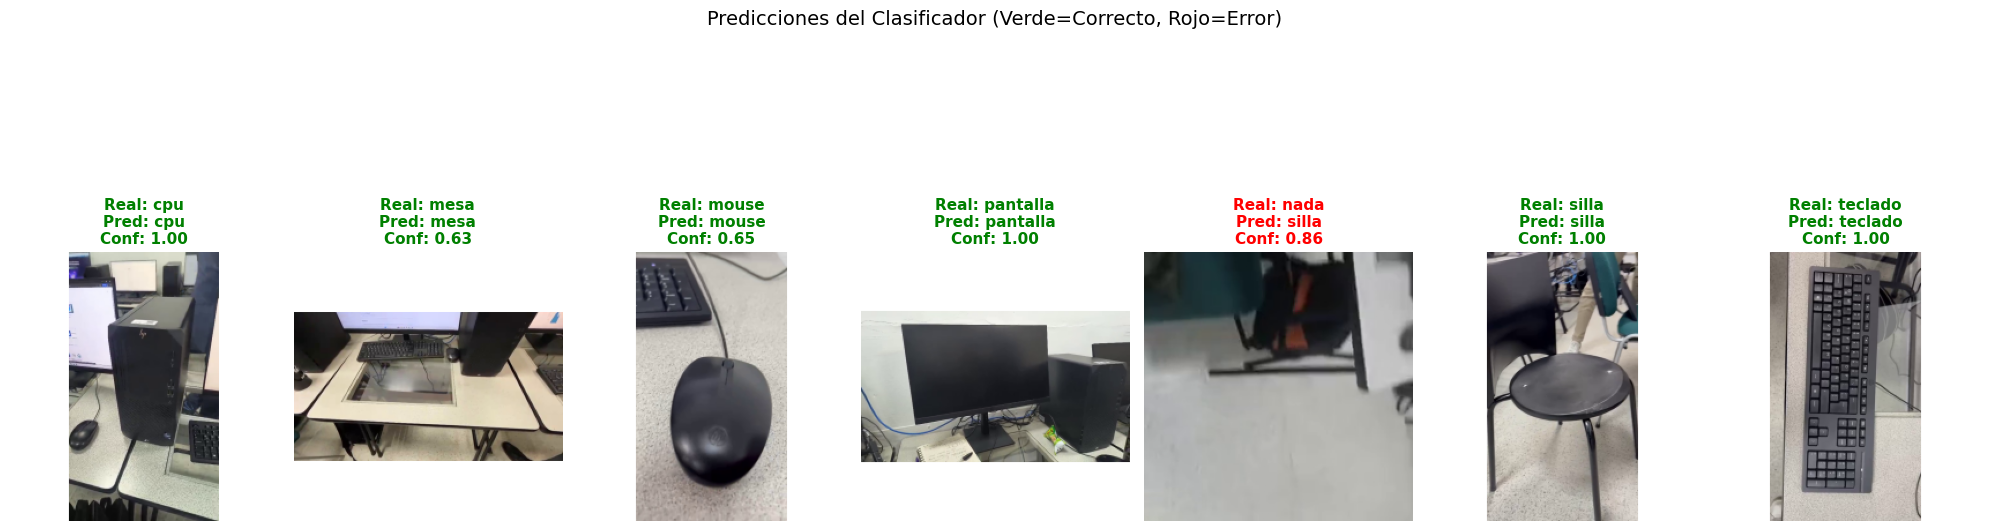


Resultados detallados por clase:

       CPU -> CORRECTO
             Muestra del test set: #117
             Top 3 predicciones:
             *        cpu: 0.999 (99.9%)
                 pantalla: 0.001 (0.1%)
                    mouse: 0.000 (0.0%)

      MESA -> CORRECTO
             Muestra del test set: #222
             Top 3 predicciones:
             *       mesa: 0.626 (62.6%)
                    mouse: 0.177 (17.7%)
                     nada: 0.101 (10.1%)

     MOUSE -> CORRECTO
             Muestra del test set: #64
             Top 3 predicciones:
             *      mouse: 0.651 (65.1%)
                  teclado: 0.145 (14.5%)
                    silla: 0.129 (12.9%)

  PANTALLA -> CORRECTO
             Muestra del test set: #4
             Top 3 predicciones:
             *   pantalla: 1.000 (100.0%)
                    mouse: 0.000 (0.0%)
                  teclado: 0.000 (0.0%)

      NADA -> ERROR
             Muestra del test set: #130
             Top 3 predicciones

In [19]:
plt.figure(figsize=(20, 8))

# Obtener división de datos originales (para imágenes)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Seleccionar una muestra aleatoria de cada clase del conjunto de prueba
selected_indices = []
selected_labels = []

print("Seleccionando muestras aleatorias por clase:")

for clase in range(NUM_CLASSES):
    # Encontrar imágenes de esta clase en el conjunto de prueba
    indices_clase_clf = np.where(y_test_clf == clase)[0]
    
    if len(indices_clase_clf) > 0:
        # Seleccionar aleatoriamente una imagen de esta clase
        idx_seleccionado = np.random.choice(indices_clase_clf)
        selected_indices.append(idx_seleccionado)
        selected_labels.append(clase)
        
        print(f"   {OBJETOS[clase]:>10}: muestra #{idx_seleccionado} seleccionada")
    else:
        print(f"   No hay imágenes de la clase {OBJETOS[clase]} en el conjunto de prueba")

# Hacer predicciones para las muestras seleccionadas
if selected_indices:
    selected_features = X_test_clf[selected_indices]
    selected_images = X_test_orig[selected_indices]  # Imágenes originales correspondientes
    predictions = classifier.predict(selected_features)
    
    n_examples = len(selected_indices)
    print(f"\nMostrando predicciones para {n_examples} muestras aleatorias:")
    
    # Mostrar cada predicción
    for i in range(n_examples):
        plt.subplot(1, n_examples, i + 1)
        
        # Obtener predicción y confianza
        pred_proba = predictions[i]
        pred_class = np.argmax(pred_proba)
        true_class = selected_labels[i]
        confidence = pred_proba[pred_class]
        
        # Mostrar imagen original
        plt.imshow(selected_images[i])
        
        # Color del título según acierto
        color = 'green' if pred_class == true_class else 'red'
        
        plt.title(f'Real: {OBJETOS[true_class]}\n'
                  f'Pred: {OBJETOS[pred_class]}\n'
                  f'Conf: {confidence:.2f}', 
                  color=color, fontsize=11, weight='bold')
        plt.axis('off')

plt.suptitle('Predicciones del Clasificador (Verde=Correcto, Rojo=Error)', 
             fontsize=14, y=0.95)
plt.tight_layout()
plt.show()

# Mostrar estadísticas detalladas de las predicciones
print("\nResultados detallados por clase:")
print("=" * 70)

for i, idx in enumerate(selected_indices):
    true_class = selected_labels[i]
    pred_proba = predictions[i]
    pred_class = np.argmax(pred_proba)
    confidence = pred_proba[pred_class]
    
    # Mostrar las 3 predicciones más probables
    top3_indices = np.argsort(pred_proba)[::-1][:3]
    
    status = "CORRECTO" if pred_class == true_class else "ERROR"
    
    print(f"\n{OBJETOS[true_class].upper():>10} -> {status}")
    print(f"{'':>12} Muestra del test set: #{idx}")
    print(f"{'':>12} Top 3 predicciones:")
    for j, top_idx in enumerate(top3_indices):
        prob = pred_proba[top_idx]
        marker = "*" if j == 0 else " "
        print(f"{'':>12} {marker} {OBJETOS[top_idx]:>10}: {prob:.3f} ({prob*100:.1f}%)")

print("\n" + "=" * 70)

# Estadísticas generales del conjunto de prueba
y_pred_all = classifier.predict(X_test_clf)
y_pred_classes = np.argmax(y_pred_all, axis=1)

print(f"\nESTADISTICAS GENERALES DEL CONJUNTO DE PRUEBA:")
print(f"   - Total muestras evaluadas: {len(X_test_clf)}")
print(f"   - Accuracy general: {np.mean(y_pred_classes == y_test_clf):.3f}")

# Accuracy por clase en todo el conjunto de prueba
print(f"\nAccuracy por clase (conjunto completo):")
for clase in range(NUM_CLASSES):
    mask = y_test_clf == clase
    if np.sum(mask) > 0:
        acc_clase = np.mean(y_pred_classes[mask] == y_test_clf[mask])
        total_clase = np.sum(mask)
        print(f"   {OBJETOS[clase]:>10}: {acc_clase:.3f} ({acc_clase*100:.1f}%) - {total_clase} muestras")
    else:
        print(f"   {OBJETOS[clase]:>10}: No hay muestras en test")

print("\nEvaluacion completada mostrando imagenes originales")

In [20]:
def evaluar_modelo_con_video(video_path, autoencoder, classifier, objetos, img_size=(233, 233), max_frames=20):
    """
    Evalúa el modelo entrenado con un video de la carpeta raw
    Extrae frames, los procesa y muestra predicciones
    """
    
    def resize_con_padding(imagen, target_size):
        """Aplicar el mismo preprocessing que en entrenamiento"""
        h, w = imagen.shape[:2]
        target_w, target_h = target_size
        
        # Calcular factor de escala
        scale_w = target_w / w
        scale_h = target_h / h
        scale = min(scale_w, scale_h)
        
        # Redimensionar manteniendo relación de aspecto
        new_w = int(w * scale)
        new_h = int(h * scale)
        resized = cv2.resize(imagen, (new_w, new_h), interpolation=cv2.INTER_AREA)
        
        # Crear imagen con fondo blanco
        resultado = np.ones((target_h, target_w, 3), dtype=imagen.dtype) * 255
        
        # Centrar la imagen
        start_x = (target_w - new_w) // 2
        start_y = (target_h - new_h) // 2
        end_x = start_x + new_w
        end_y = start_y + new_h
        
        resultado[start_y:end_y, start_x:end_x] = resized
        return resultado
    
    print(f"Evaluando modelo con video: {video_path}")
    
    # Verificar si el video existe
    if not os.path.exists(video_path):
        print(f"Error: Video no encontrado en {video_path}")
        return
    
    # Abrir video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: No se pudo abrir el video {video_path}")
        return
    
    # Obtener información del video
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0
    
    print(f"Información del video:")
    print(f"   - FPS: {fps:.2f}")
    print(f"   - Total frames: {total_frames}")
    print(f"   - Duración: {duration:.2f} segundos")
    print(f"   - Extrayendo {max_frames} frames para evaluación")
    
    # Calcular intervalo de frames
    if total_frames <= max_frames:
        frame_interval = 1
        max_frames = total_frames
    else:
        frame_interval = total_frames // max_frames
    
    # Extraer y procesar frames
    frames_procesados = []
    frames_originales = []
    frame_count = 0
    extracted_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or extracted_count >= max_frames:
            break
            
        if frame_count % frame_interval == 0:
            # Convertir BGR a RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames_originales.append(frame_rgb.copy())
            
            # Aplicar preprocessing
            frame_processed = resize_con_padding(frame_rgb, img_size)
            frame_normalized = frame_processed.astype(np.float32) / 255.0
            frames_procesados.append(frame_normalized)
            
            extracted_count += 1
            
        frame_count += 1
    
    cap.release()
    
    # Convertir a arrays numpy
    frames_array = np.array(frames_procesados)
    print(f"\nFrames extraídos y procesados: {len(frames_array)}")
    print(f"Forma de frames procesados: {frames_array.shape}")
    
    # Extraer features con el encoder
    print("Extrayendo features con el encoder...")
    features = autoencoder.encode(frames_array).numpy()
    
    # Hacer predicciones
    print("Realizando predicciones...")
    predictions = classifier.predict(features)
    predicted_classes = np.argmax(predictions, axis=1)
    confidences = np.max(predictions, axis=1)
    
    # Mostrar resultados
    print(f"\nResultados de la evaluación:")
    print("=" * 60)
    
    # Contar predicciones por clase
    unique_preds, counts = np.unique(predicted_classes, return_counts=True)
    
    print(f"Distribución de predicciones:")
    for clase, count in zip(unique_preds, counts):
        porcentaje = (count / len(predicted_classes)) * 100
        print(f"   {objetos[clase]:>10}: {count:>2} frames ({porcentaje:>5.1f}%)")
    
    # Predicción más frecuente
    clase_mas_frecuente = unique_preds[np.argmax(counts)]
    confianza_promedio = np.mean(confidences[predicted_classes == clase_mas_frecuente])
    
    print(f"\nPredicción final del video:")
    print(f"   Clase predominante: {objetos[clase_mas_frecuente]}")
    print(f"   Confianza promedio: {confianza_promedio:.3f}")
    
    # Visualizar algunos frames con predicciones
    n_ejemplos = min(8, len(frames_originales))
    plt.figure(figsize=(20, 8))
    
    for i in range(n_ejemplos):
        plt.subplot(2, n_ejemplos // 2, i + 1)
        plt.imshow(frames_originales[i])
        
        pred_class = predicted_classes[i]
        confidence = confidences[i]
        
        color = 'green' if confidence > 0.7 else 'orange' if confidence > 0.5 else 'red'
        
        # Destacar si es la clase predominante
        predominante_marker = " ★" if pred_class == clase_mas_frecuente else ""
        
        plt.title(f'Frame {i+1}\n{objetos[pred_class]}{predominante_marker}\nConf: {confidence:.3f}', 
                 color=color, fontsize=10, weight='bold')
        plt.axis('off')
    
    # Título principal con información de la clase predominante
    main_title = f'Evaluación del video: {os.path.basename(video_path)}\nClase Predominante: {objetos[clase_mas_frecuente]} (Confianza promedio: {confianza_promedio:.3f})'
    plt.suptitle(main_title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
    
    return {
        'predicciones': predicted_classes,
        'confidencias': confidences,
        'clase_predominante': objetos[clase_mas_frecuente],
        'confianza_promedio': confianza_promedio,
        'distribucion': dict(zip([objetos[i] for i in unique_preds], counts))
    }

In [21]:
# Listar videos disponibles en la carpeta raw
print("Videos disponibles en la carpeta raw:")
videos_disponibles = glob.glob(os.path.join(RAW_DIR, "*.mp4"))

for i, video in enumerate(videos_disponibles):
    nombre_video = os.path.basename(video)
    print(f"   {i+1}. {nombre_video}")

Videos disponibles en la carpeta raw:
   1. 20242695001_teclado.mp4
   2. 20241695014_silla.mp4
   3. data_raw_2025169005_cpu.mp4
   4. 20251595006_Mesa.mp4
   5. 20252695003_pantalla.mp4
   6. 20252695008_pantalla.mp4
   7. 20251695010_mouse.mp4
   8. 20251595006_Teclado.mp4
   9. 20252695003_mouse.mp4
   10. 20251695007_mesa.mp4
   11. 20251595004_cpu.mp4
   12. 20251695011_mouse.mp4
   13. 20242595003_pantalla.mp4
   14. 20252695008_mouse.mp4
   15. 20251695011_pantalla.mp4
   16. 20252695009_cpu.mp4
   17. 20251595006_Pantalla.mp4
   18. 20251595001_monitor.mp4
   19. 20242595003_mouse.mp4
   20. 20251595006_Cpu.mp4
   21. 20242595005_ruido.mp4
   22. data_raw_2025169005_ruido.mp4
   23. 20252695009_mouse.mp4
   24. 20242695001_cpu.mp4
   25. 20172167090_silla.mp4
   26. 20251595004_mesa.mp4
   27. 20242595005_pantalla.mp4
   28. 20241196002_silla.mp4
   29. 20251695011_nada.mp4
   30. 20241695014_teclado.mp4
   31. 20251695011_teclado.mp4
   32. 20251695010_teclado.mp4
   33. data


Evaluando con: 20251695010_mouse.mp4
Evaluando modelo con video: ../raw/20251695010_mouse.mp4
Información del video:
   - FPS: 29.95
   - Total frames: 136
   - Duración: 4.54 segundos
   - Extrayendo 20 frames para evaluación

Frames extraídos y procesados: 20
Forma de frames procesados: (20, 233, 233, 3)
Extrayendo features con el encoder...
Realizando predicciones...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Resultados de la evaluación:
Distribución de predicciones:
         mesa:  5 frames ( 25.0%)
        mouse: 14 frames ( 70.0%)
        silla:  1 frames (  5.0%)

Predicción final del video:
   Clase predominante: mouse
   Confianza promedio: 0.878


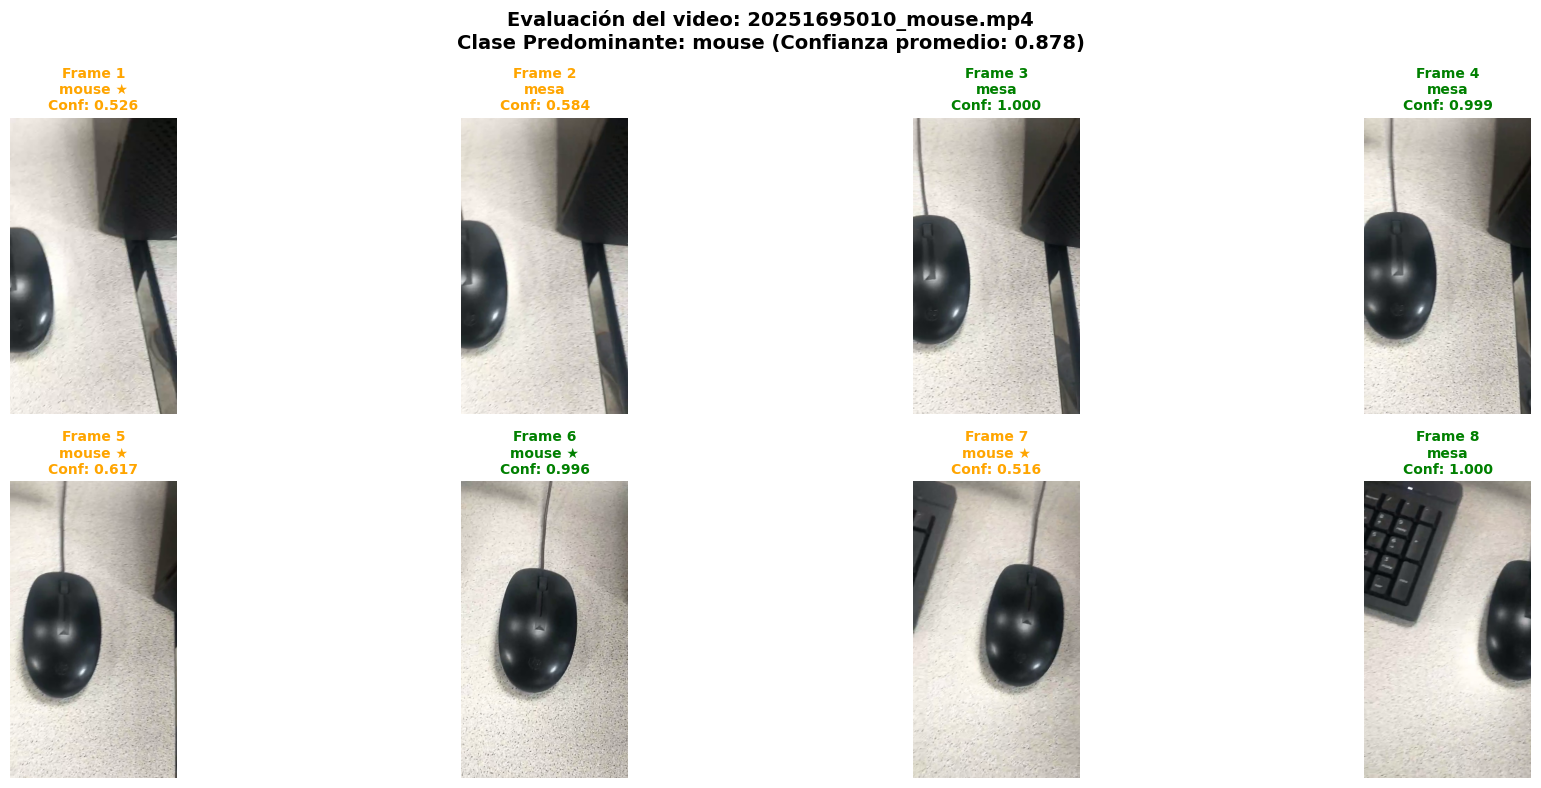

In [22]:
video = 7
cantidad_frames = 20

if videos_disponibles:
    
    # Evaluar con el primer video encontrado
    video_seleccionado = videos_disponibles[video - 1]  
    
    print(f"\nEvaluando con: {os.path.basename(video_seleccionado)}")
    print("=" * 60)
    
    # Realizar evaluación
    resultados = evaluar_modelo_con_video(
        video_seleccionado, 
        autoencoder, 
        classifier, 
        OBJETOS, 
        IMG_SIZE,
        max_frames=cantidad_frames  # Ajusta el número de frames a evaluar
    )
    
else:
    print("No se encontraron videos .mp4 en la carpeta raw")
    print(f"Verificar contenido de: {RAW_DIR}")

##  Guardar Modelos Entrenados

In [23]:
# Crear directorio models si no existe
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

autoencoder_path = os.path.join(models_dir, f"{CODIGO}_autoencoder.weights.h5")
classifier_path = os.path.join(models_dir, f"{CODIGO}_classifier.h5")

# Guardar modelos
autoencoder.save_weights(autoencoder_path)  # Usar save_weights para modelo personalizado
classifier.save(classifier_path)

print("Modelos guardados:")
print(f"   - Autoencoder weights: {autoencoder_path}")
print(f"   - Clasificador: {classifier_path}")


def cargar_autoencoder(weights_path, latent_dim, shape):
    """Función para recrear y cargar el autoencoder personalizado"""
    ae = Autoencoder(latent_dim, shape)
    # Construir el modelo con datos de ejemplo
    sample = tf.random.normal((1,) + shape)
    _ = ae(sample)
    # Cargar pesos
    ae.load_weights(weights_path)
    return ae

Modelos guardados:
   - Autoencoder weights: ../models/20251595006_autoencoder.weights.h5
   - Clasificador: ../models/20251595006_classifier.h5
